In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2

In [9]:
base_dir = 'chest_xray'
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

In [10]:
train_neg = glob(os.path.join(train_path, 'NORMAL/*.jpeg'))
train_pos = glob(os.path.join(train_path, 'PNEUMONIA/*.jpeg'))
val_neg = glob(os.path.join(val_path, 'NORMAL/*.jpeg'))
val_pos = glob(os.path.join(val_path, 'PNEUMONIA/*.jpeg'))
test_neg = glob(os.path.join(test_path, 'NORMAL/*.jpeg'))
test_pos = glob(os.path.join(test_path, 'PNEUMONIA/*.jpeg'))

In [11]:
def extract_image_properties(image_paths):
    data = []
    for img_path in image_paths: 
        img = cv2.imread(img_path)
        properties = {
            'path': img_path,
            'label': os.path.basename(os.path.dirname(img_path)),
           'dataset': os.path.basename(os.path.dirname(os.path.dirname(img_path))),
            'max': img.max(),
            'min': img.min(),
            'mean': img.mean(),
            'std': img.std(),
            'height': img.shape[0],
            'width': img.shape[1]
        }
        data.append(properties)

    df_img = pd.DataFrame(data)
    
    return df_img

In [12]:
df_train_neg = extract_image_properties(train_neg)
df_train_pos = extract_image_properties(train_pos)
df_val_neg = extract_image_properties(val_neg)
df_val_pos = extract_image_properties(val_pos)
df_test_neg = extract_image_properties(test_neg)
df_test_pos = extract_image_properties(test_pos)

df_all = pd.concat([df_train_neg, df_train_pos, df_val_neg, df_val_pos, df_test_neg, df_test_pos])

In [13]:
df_all.to_csv('xray_images_properties.csv', index=False)

In [14]:
df_all = pd.read_csv('xray_images_properties.csv')
df_all.head()

,path,label,dataset,max,min,mean,std,height,width
0,C:/Users/Zeyad Baloch/Desktop/chest_xray\train...,NORMAL,train,255,0,128.907478,62.301030,1858,2090
1,C:/Users/Zeyad Baloch/Desktop/chest_xray\train...,NORMAL,train,255,0,100.650624,59.808347,1152,1422
2,C:/Users/Zeyad Baloch/Desktop/chest_xray\train...,NORMAL,train,255,0,121.971530,68.856428,1434,1810
3,C:/Users/Zeyad Baloch/Desktop/chest_xray\train...,NORMAL,train,255,0,132.986188,64.970663,1279,1618
4,C:/Users/Zeyad Baloch/Desktop/chest_xray\train...,NORMAL,train,255,0,106.224797,65.088725,1125,1600


In [63]:
def plot_class_distribution(df, dataset_name):
   
    df_subset = df[df['dataset'] == dataset_name]
   
    labels_named = df_subset['label']
    
    sns.countplot(x=labels_named, hue=labels_named, palette='Set2', legend=False)
    plt.title(f"{dataset_name.capitalize()} Set Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


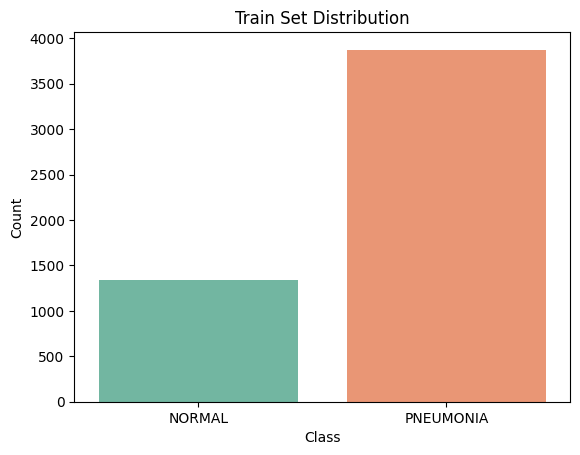

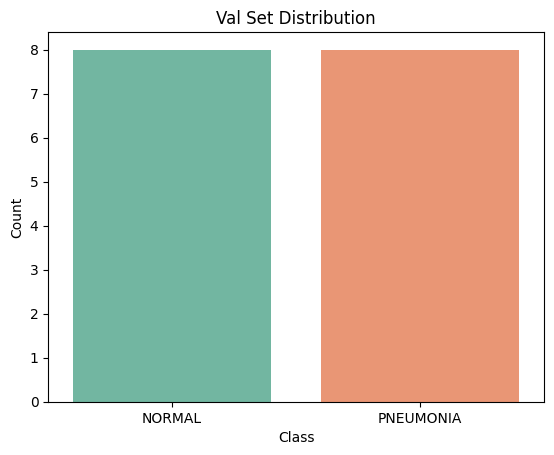

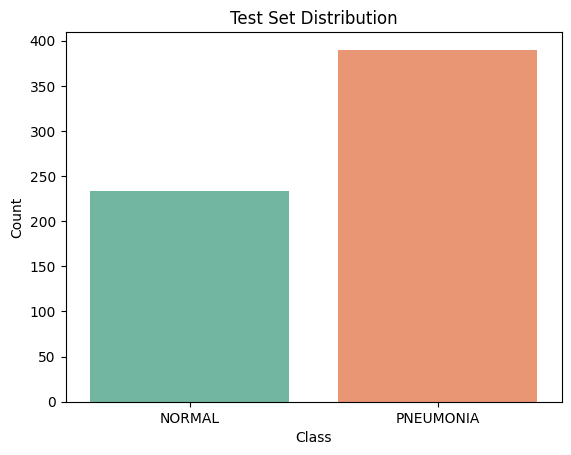

In [64]:
plot_class_distribution(df_all, "train")
plot_class_distribution(df_all, "val")
plot_class_distribution(df_all, "test")

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, metrics

from tensorflow.keras.applications import InceptionV3


In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_val_df = df_all[(df_all['dataset'] == 'train') | (df_all['dataset'] == 'val')]
valid_size = 0.2
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)
train_df['dataset'] = 'train'
val_df['dataset'] = 'val'

test_df = df_all[df_all['dataset'] == 'test']


print(len(train_df),"Images Belongs To Training Class\n", )
print(len(val_df),"Images Belongs To Validation Class\n")
print(len(test_df),"Images Belongs To Testing Class\n")


4185 Images Belongs To Training Class

1047 Images Belongs To Validation Class

624 Images Belongs To Testing Class



In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

img_size = (224, 224)
batch_size = 64 # 32, 64, 128

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = True,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [54]:
base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(2, activation='softmax')
])

for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 97s 1us/step 


In [55]:
count_normal = len(train_df[train_df['label'] == 'NORMAL'])
count_pneumonia = len(train_df[train_df['label'] == 'PNEUMONIA'])
count_total = len(train_df)

# Scaling by total/2 helps keep the loss to a similar magnitude - the sum of the weights of all examples stays the same.
weight_for_0 = (1 / count_normal) * (count_total / 2.0)
weight_for_1 = (1 / count_pneumonia) * (count_total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}



In [56]:
# Define callbacks
checkpoint_path = "best_of_best_model.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      monitor='val_loss', 
                                      save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5)

In [65]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weight,
    callbacks=[checkpoint_callback, early_stopping_callback]
)




Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8470 - loss: 0.3581   

C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 1357s 20s/step - accuracy: 0.8480 - loss: 0.3559 - val_accuracy: 0.6256 - val_loss: 6.7349
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1427s 20s/step - accuracy: 0.9530 - loss: 0.1206 - val_accuracy: 0.8949 - val_loss: 0.5333
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1434s 22s/step - accuracy: 0.9607 - loss: 0.0946 - val_accuracy: 0.9045 - val_loss: 0.5240
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 34424s 528s/step - accuracy: 0.9614 - loss: 0.0836 - val_accuracy: 0.9312 - val_loss: 0.3357
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1511s 21s/step - accuracy: 0.9784 - loss: 0.0693 - val_accuracy: 0.9351 - val_loss: 0.2591
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 7147s 110s/step - accuracy: 0.9747 - loss: 0.0723 - val_accuracy: 0.9599 - val_loss: 0.1742
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 862s 13s/step - accuracy: 0.9785 - loss: 0.0566 - val_accuracy: 0.9656 - val_loss: 0.1751
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 833s 13s/step - accuracy: 0.9785 - loss: 0.0565 - val_accuracy: 0.94

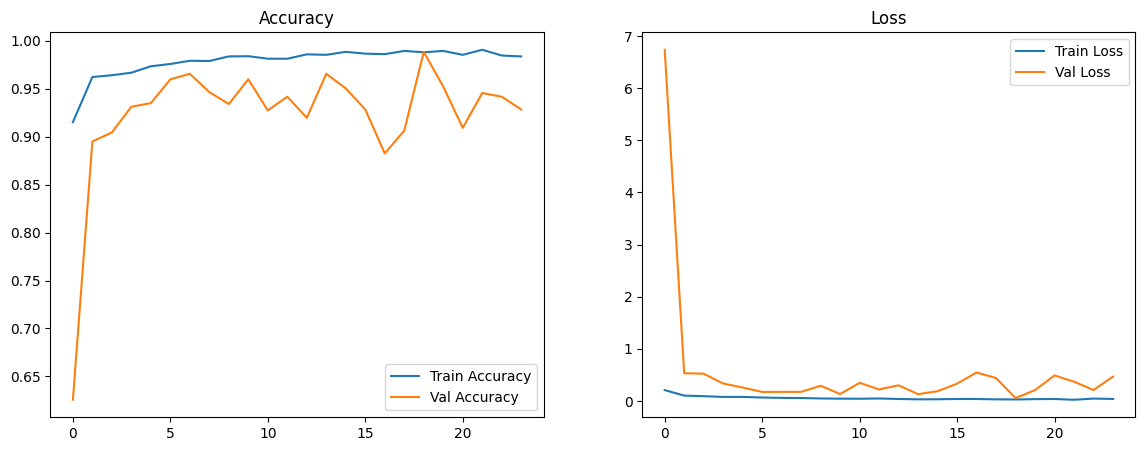

In [67]:
#Plot Training Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [68]:
test_generator.reset()

y_probs = model.predict(test_generator, verbose=1) 
y_preds = np.argmax(y_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

10/10 ━━━━━━━━━━━━━━━━━━━━ 484s 16s/step  


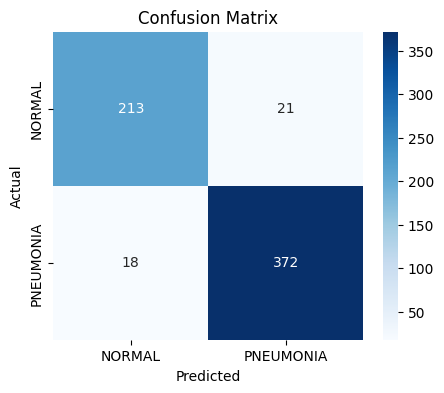

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.91      0.92       234
   PNEUMONIA       0.95      0.95      0.95       390

    accuracy                           0.94       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



In [72]:
# Probability of class 1
y_prob_class1 = y_probs[:, 1]

AUC Score: 0.9839


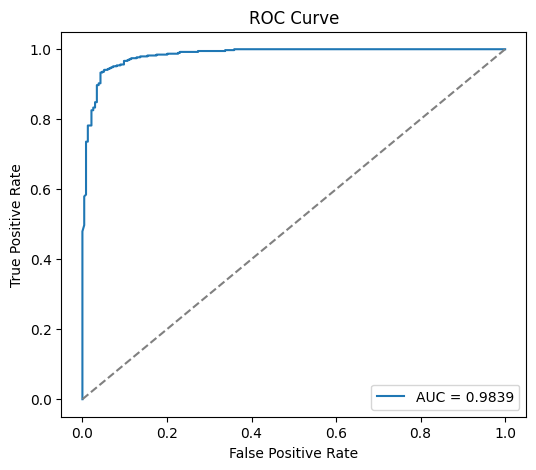

In [73]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute AUC
auc = roc_auc_score(y_true, y_prob_class1)
print(f"AUC Score: {auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob_class1)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [74]:
model.save(f'final_x-ray_model.keras')
print('Model Saved!')

Model Saved!
